In [2]:
import sys

sys.path.append('.')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.optim as optim
import numpy as np

np.set_printoptions(linewidth=np.inf, precision=2, floatmode='fixed')

In [5]:
from datamining.mine_json_data import mineData, preparePDData
from indicators.prepare_indicators import prepareIndicators
from predictions.prepare_model_data import prepareModelData, prepareDataLoaders
from common.datasets import TimeseriesDataset
from common.models import LSTMLinear
from common.training import fit_scaled
from common.checkpoints import loadLSTMLinearFromCheckpoint
from common.losses import R2Loss
from common.plots import printScaledScores
from common.training import getMSEScore, getR2Score


In [6]:

df_1d = preparePDData("../data/raw/binance_BTCUSDT_1d.json")

In [7]:
column_y = "price_close"
column_names = ["price_open", "price_close", "price_high", "price_low", "volume"]
model_data = prepareModelData(df_1d, column_y=column_y, column_names=column_names)
train_dl, test_dl, val_dl = prepareDataLoaders(model_data)

In [8]:
num_epochs = 250
learning_rate = 0.001
weight_decay = 1e-2
patience = 15
model_args = {
    'input_size': len(column_names), 
    'hidden_size': 550, 
    'num_layers': 2, 
    'output_size': 1, 
    'scaler': model_data["ss_y"]
}

In [19]:
model = LSTMLinear(**model_args)

optimizer_args = { 'params': list(model.parameters()), 'lr': learning_rate, 'weight_decay': weight_decay }
optimizer = optim.AdamW(**optimizer_args)
loss_fn = torch.nn.MSELoss()

filename = "BTCUSDT_1d"

fit_scaled(
    model=model, optimizer=optimizer, loss_fn=loss_fn, 
    train_dl=train_dl, val_dl=val_dl, epochs=num_epochs,
    patience=patience,
    save_checkpoints=True, model_args=model_args, optimizer_args=optimizer_args,
    checkpoint_path= f'../data/checkpoints/checkpoint_{filename}.pkl',
    checkpoint_f1_path= f'../data/checkpoints/checkpoint_{filename}_f1.pkl'
)
print('done')

Epoch    1/250 = train loss: 1.0011, train MSE: 0.9830 | R2: 0.0170, val MSE: 0.1263 | R2: -0.9769, time_taken: 0.05708479881286621s
Epoch    2/250 = train loss: 0.9830, train MSE: 0.9631 | R2: 0.0369, val MSE: 0.1251 | R2: -0.9576, time_taken: 0.056336164474487305s
Epoch    3/250 = train loss: 0.9633, train MSE: 0.9401 | R2: 0.0599, val MSE: 0.1230 | R2: -0.9240, time_taken: 0.05914497375488281s
Epoch    4/250 = train loss: 0.9410, train MSE: 0.9128 | R2: 0.0872, val MSE: 0.1197 | R2: -0.8730, time_taken: 0.05918002128601074s
Epoch    5/250 = train loss: 0.9131, train MSE: 0.8802 | R2: 0.1198, val MSE: 0.1152 | R2: -0.8018, time_taken: 0.05807900428771973s
Epoch    6/250 = train loss: 0.8799, train MSE: 0.8413 | R2: 0.1587, val MSE: 0.1093 | R2: -0.7101, time_taken: 0.05718183517456055s
Epoch    7/250 = train loss: 0.8419, train MSE: 0.7955 | R2: 0.2045, val MSE: 0.1022 | R2: -0.5986, time_taken: 0.06850695610046387s
Epoch    8/250 = train loss: 0.7959, train MSE: 0.7423 | R2: 0.2577,

[[0,
  1.0011199712753296,
  0.9829962821223376,
  0.01700372084758317,
  0.12634745115238805,
  -0.976912891922471],
 [1,
  0.9829624891281128,
  0.9631261562372356,
  0.03687384667265159,
  0.12511034032203502,
  -0.9575562659917103],
 [2,
  0.9632887244224548,
  0.940082895370627,
  0.05991710746963985,
  0.12296295083879356,
  -0.923956839056864],
 [3,
  0.9410247802734375,
  0.9128099907569162,
  0.08719001200095111,
  0.11970417845492418,
  -0.8729680056553712],
 [4,
  0.9131410121917725,
  0.8801542984084935,
  0.1198457042507114,
  0.11515781474609652,
  -0.8018326962733904],
 [5,
  0.8799235820770264,
  0.8413010013463967,
  0.1586990011954209,
  0.10929392083651308,
  -0.710082468144613],
 [6,
  0.8419257998466492,
  0.7955384211099887,
  0.20446158129356662,
  0.10216758562390739,
  -0.5985792773365175],
 [7,
  0.7959216833114624,
  0.7422610471123454,
  0.25773895513024336,
  0.09409840396504314,
  -0.4723237090351575],
 [8,
  0.7425413727760315,
  0.681016034233334,
  0.31

In [20]:
best_model = loadLSTMLinearFromCheckpoint(f'../data/checkpoints/checkpoint_{filename}.pkl')
best_model_f1 = loadLSTMLinearFromCheckpoint(f'../data/checkpoints/checkpoint_{filename}_f1.pkl')

printScaledScores(test_dl, val_dl, best_model)
printScaledScores(test_dl, val_dl, best_model_f1)

test MSE: 0.0117 | R2: 0.8071, val MSE: 0.0142 | R2: 0.8206
test MSE: 0.0102 | R2: 0.8818, val MSE: 0.0106 | R2: 0.8742


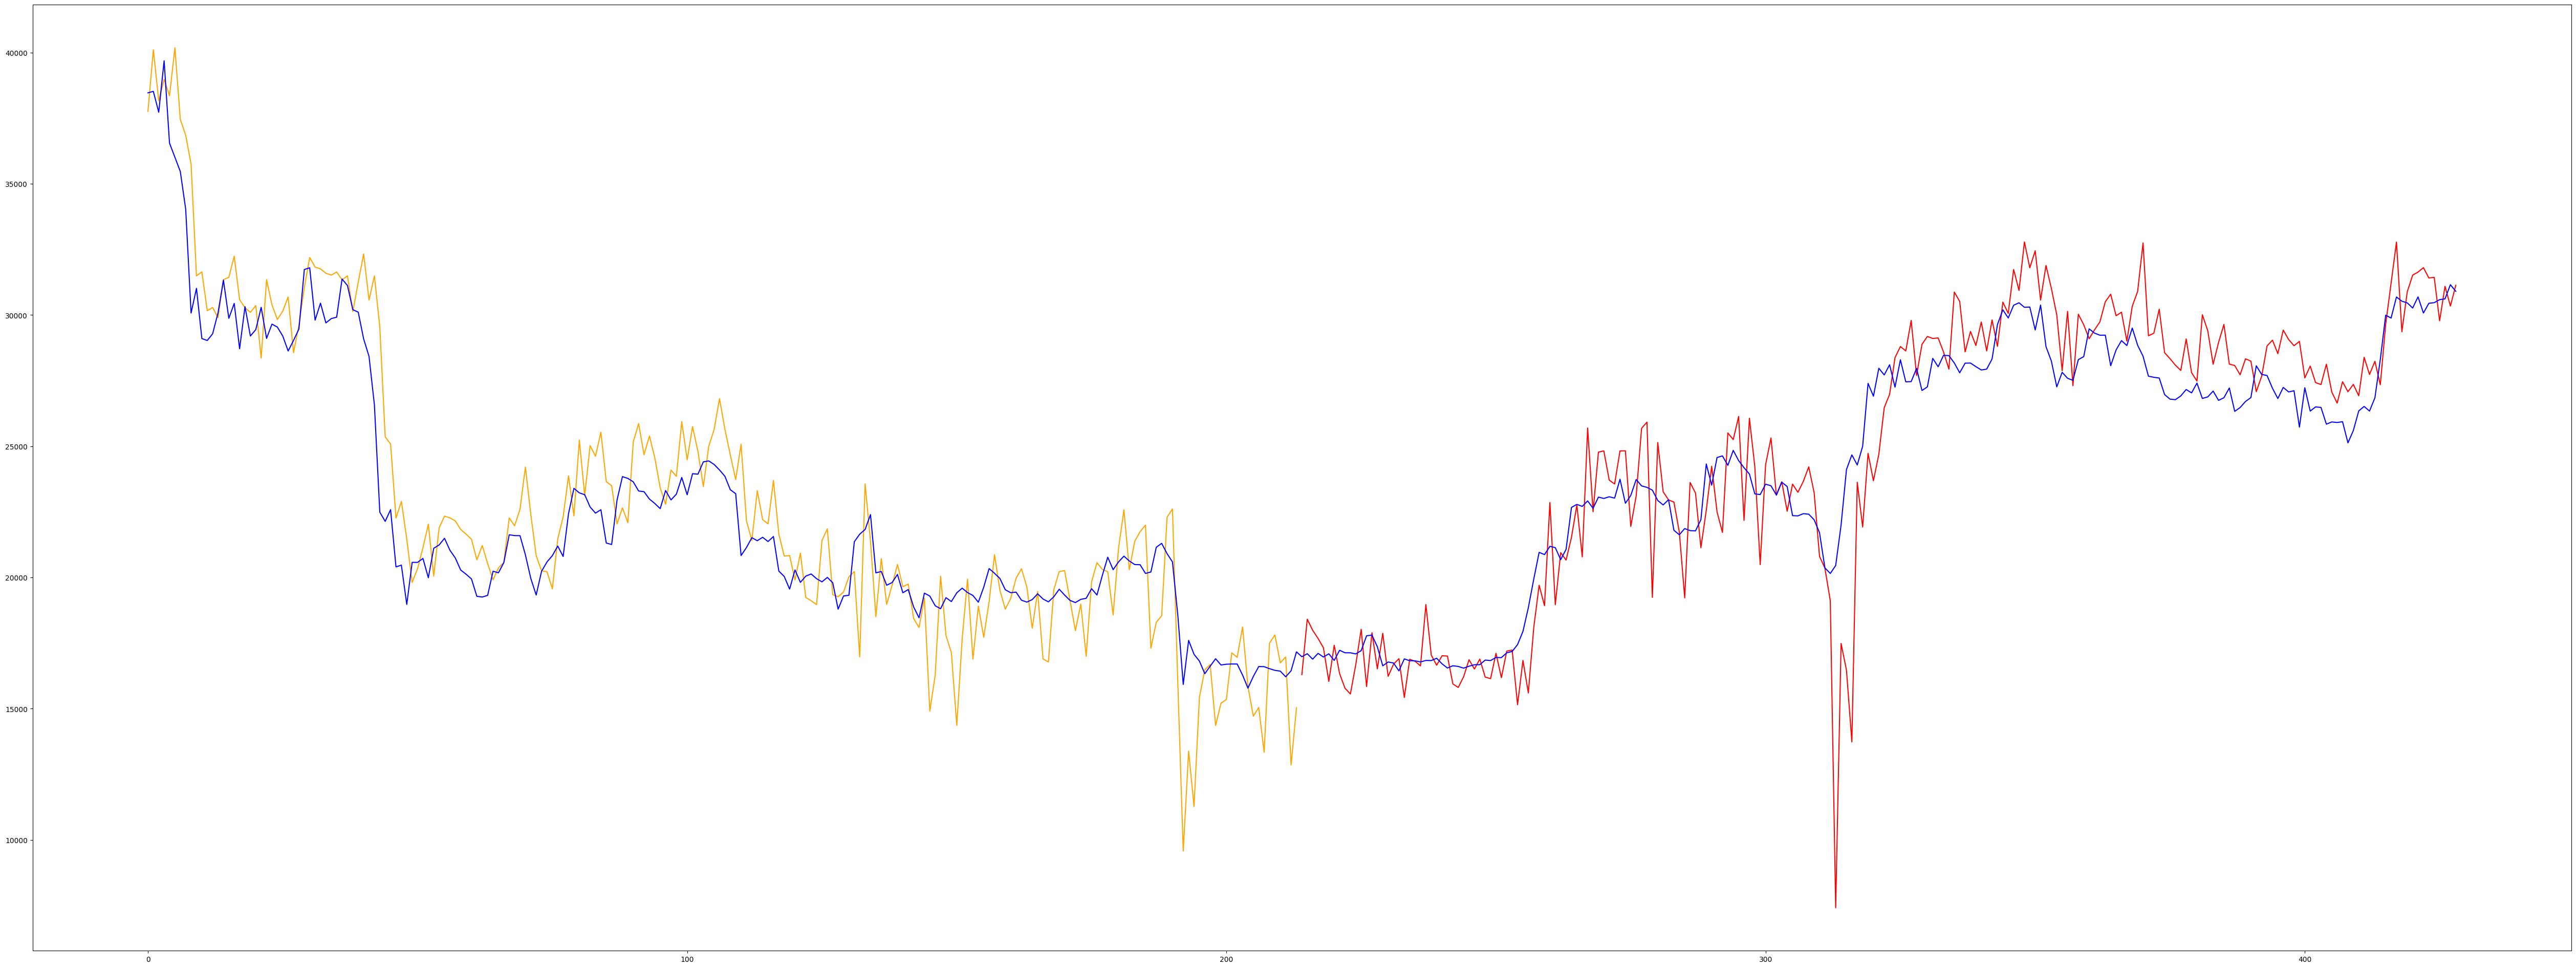

In [21]:
import matplotlib.pyplot as plt

from common.plots import plotTimeseries

test_score, y_true_test, y_pred_test = getMSEScore(test_dl, best_model, best_model.scaler)
val_score, y_true_val, y_pred_val = getMSEScore(val_dl, best_model, best_model.scaler)
plotTimeseries(y_true_test, y_pred_test, y_true_val, y_pred_val)